# Intel Image Classification

This dataset contains a large number of 32 x 32 thumbnail images containing aerial photos of a columnar cactus (Neobuxbaumia tetetzo).

Kaggle has resized the images from the original dataset to make them uniform in size. The file name of an image corresponds to its id.

You must create a classifier capable of predicting whether an images contains a cactus.

## Download the data
https://www.kaggle.com/c/aerial-cactus-identification/data

## Parameters

In [1]:
train_file_path = 'data/train'
test_file_path = 'data/test'
csv_file_path = 'data/train.csv'

# re-size all the images to this
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_CHANNELS = 3

# Load Dataset

In [2]:
import os
import cv2
from sklearn.utils import shuffle
from numpy import array
import pandas as pd

def load_data(file_path, csv_file_contents):
    images = []
    labels = []
    
    for row in csv_file_contents:
        file_name = row[0]
        isCactus = row[1]
        
        image = cv2.imread(file_path+ '/'+ file_name)
        image = image
        images.append(image)
        
        labels.append(isCactus) 

    images = array(images)
    labels = array(labels)
    return shuffle(images,labels,random_state=0)

csv_file_contents = pd.read_csv(csv_file_path)
csv_file_contents = array(csv_file_contents)

train_images, train_labels = load_data(train_file_path, csv_file_contents)

In [3]:
print ("train_images shape : " + str(train_images.shape))
print ("train_labels shape : " + str(train_labels.shape))

train_images shape : (17500, 32, 32, 3)
train_labels shape : (17500,)


In [4]:
train_x = train_images/255.0
train_y = train_labels

## Display Some images

Cactus Present 


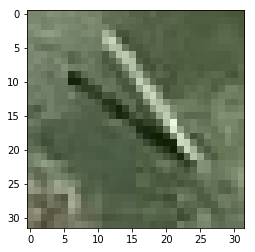

Cactus Present 


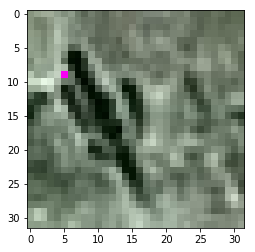

In [6]:
import matplotlib.pyplot as plt
def show_image(img):
    img = img
    plt.imshow(img)
    plt.gray()
    plt.show()
import random
for i in range(2):
    pos = random.randint(0,train_images.shape[0])
    print('Cactus Present ' if train_labels[pos] else 'Cactus Not present')
    show_image(train_images[pos]*255)


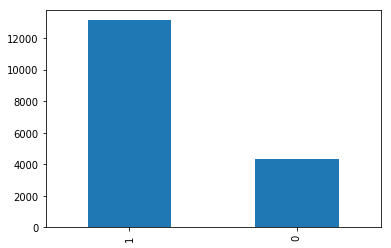

In [7]:
import pandas as pd
pd_train_labels = pd.DataFrame({'labels': train_labels[:]})
pd.value_counts(pd_train_labels['labels']).plot.bar()

# Build Models 

In [8]:
def plot_accuracy(history):    

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
def plot_loss(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

Using TensorFlow backend.


## Model 1 - Artificial Neural Network

In [10]:
def get_model1():
    model = Sequential()    
    model.add(Flatten(input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))    
    model.add(Dense(1024, activation = "relu"))    
    model.add(Dropout(0.1))    
    model.add(Dense(512, activation = "relu"))    
    model.add(Dropout(0.1))   
    model.add(Dense(128, activation = "relu"))    
    model.add(Dropout(0.1))  
    model.add(Dense( 1, activation = "relu"))    
    optimizer = RMSprop(lr=0.00001, rho=0.9, epsilon=1e-08, decay=0.0)    
    model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])    
    return model

In [12]:
from sklearn.utils import class_weight
class_weight.compute_class_weight('balanced',      np.unique(train_y),train_y)
class_weights = [2.00504125, 0.6661084]

In [13]:
model1 = get_model1()
model1.summary()
class_weight = {0: 2.00504125, 1: 0.6661084}
history = model1.fit(x=train_x, y=train_y, batch_size=64, epochs=15, validation_split=0.2, class_weight=class_weight)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)      

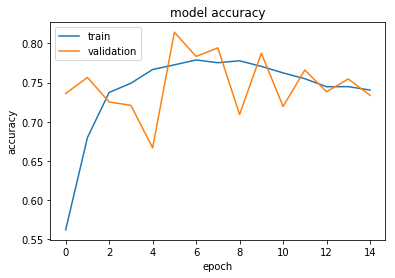

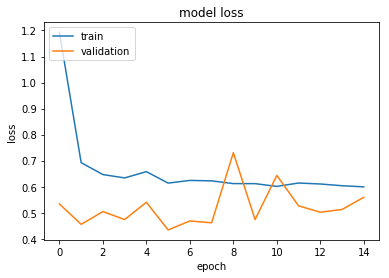

In [14]:
plot_accuracy(history)
plot_loss(history)

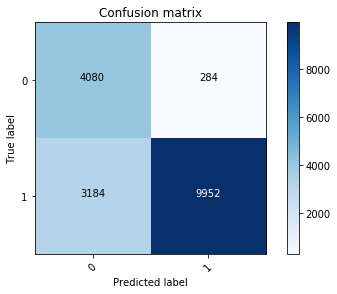

In [15]:
true = train_y
pred = model1.predict_classes(train_x)
confusion_mtx = confusion_matrix(true, pred) 
plot_confusion_matrix(confusion_mtx, classes = [0,1]) 

## Model2 - Convolutional Neural Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
__________

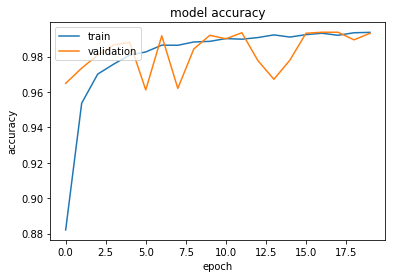

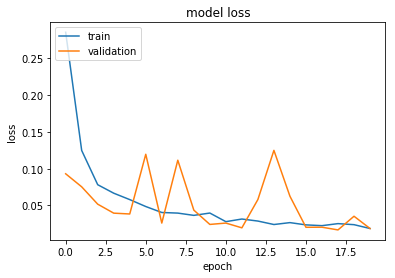

In [16]:
def get_model2():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(3,3)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(3,3)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    
    model.add(Dense(256, activation = "relu"))    
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation = "sigmoid"))
    
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)    
    model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"]) 
    
    return model

model2 = get_model2()
model2.summary()
history2 = model2.fit(x=train_x, y=train_y, batch_size=64, epochs=20, validation_split=0.2, class_weight=class_weights )
plot_accuracy(history2)
plot_loss(history2)

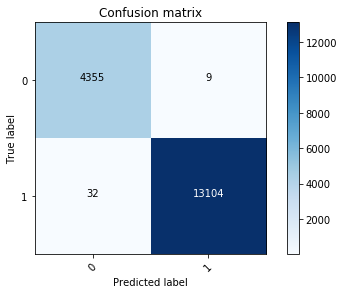

In [17]:
true = train_y
pred = model2.predict_classes(train_x)
confusion_mtx = confusion_matrix(true, pred) 
plot_confusion_matrix(confusion_mtx, classes = [0,1]) 

## Model 3 - Bigger Convolutional Neural Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 31, 200)       2600      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 180)       144180    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 180)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 180)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 180)       129780    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 140)       100940    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 100)       56100     
__________

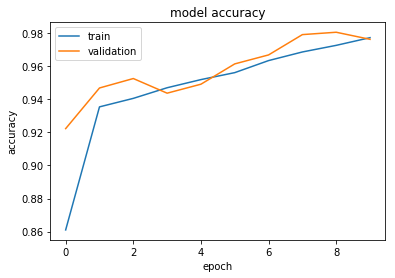

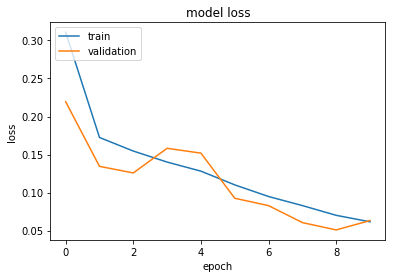

In [18]:
def get_model3():
    
    model = Sequential()

    model.add(Conv2D(filters = 200, kernel_size = (2,2),
                     activation ='relu', input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
    model.add(Conv2D(filters = 180, kernel_size = (2,2), activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))


    model.add(Conv2D(filters = 180, kernel_size = (2,2),  activation ='relu'))
    model.add(Conv2D(filters = 140, kernel_size = (2,2),  activation ='relu'))
    model.add(Conv2D(filters = 100, kernel_size = (2,2),  activation ='relu'))
    model.add(Conv2D(filters = 50, kernel_size = (2,2),  activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,5)))
    model.add(Dropout(0.2))


    model.add(Flatten())
    
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation = "relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation = "sigmoid"))
    
    optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)    
    model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"]) 

#     optimizer=Adam(lr=0.0001)
#     model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

model3= get_model3()
model3.summary()
history3 = model3.fit(x=train_x, y=train_y, batch_size=64, epochs=10, validation_split=0.2, class_weight=class_weights  )
plot_accuracy(history3)
plot_loss(history3)

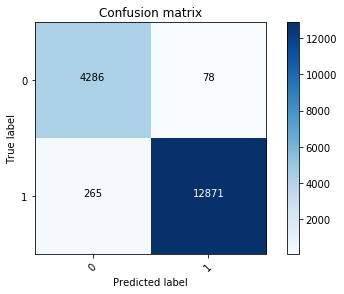

In [19]:
true = train_y
pred = model3.predict_classes(train_x)
confusion_mtx = confusion_matrix(true, pred) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

# Model 4 : Pretrained VGG16

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

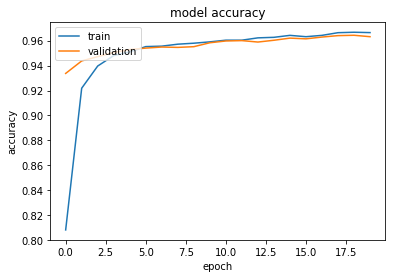

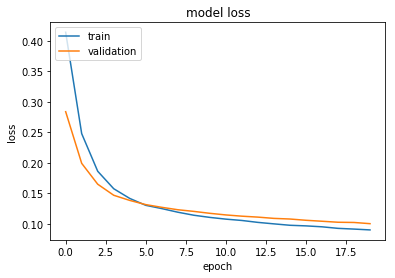

In [20]:
def get_model4():
    
    vgg = VGG16(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS), weights='imagenet', include_top=False)
    for layer in vgg.layers:
      layer.trainable = False    
    
    x = Flatten()(vgg.output)

    x = Dense(128, activation = "relu")(x)
    x = (Dropout(0.2))(x)    
    
    x = Dense(1, activation = "sigmoid")(x)
    
    model = Model(inputs=vgg.input, outputs=x)
        
    optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)    
    model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"]) 
    
    return model
    
model4= get_model4()
model4.summary()
history4 = model4.fit(x=train_x, y=train_y, batch_size=64, epochs=20, validation_split=0.2, class_weight=class_weights  )
plot_accuracy(history4)
plot_loss(history4)

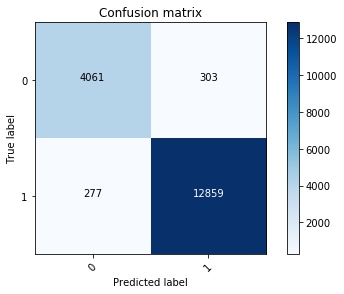

In [22]:
true = train_y
pred  = model4.predict(train_x)
pred = np.where(pred>0.5, 1, 0)
confusion_mtx = confusion_matrix(true, pred) 
plot_confusion_matrix(confusion_mtx, classes = [0,1]) 

# Test On new Images

In [23]:
# Load Test Images
test_images = []
test_file_names = []
for image_file_path in os.listdir(test_file_path ):  
    test_file_names.append(image_file_path)
    image = cv2.imread(test_file_path + '/'+ image_file_path)
    image = cv2.resize(image,(IMAGE_WIDTH,IMAGE_HEIGHT))
    image = image/255
    test_images.append(image)
test_images = array(test_images)
print(test_images.shape)

(4000, 32, 32, 3)


In [24]:
# pred  = model4.predict(test_images)
# pred = np.where(pred>0.5, 1, 0)
# pred

pred = model2.predict_classes(train_x)


/home/vesper/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


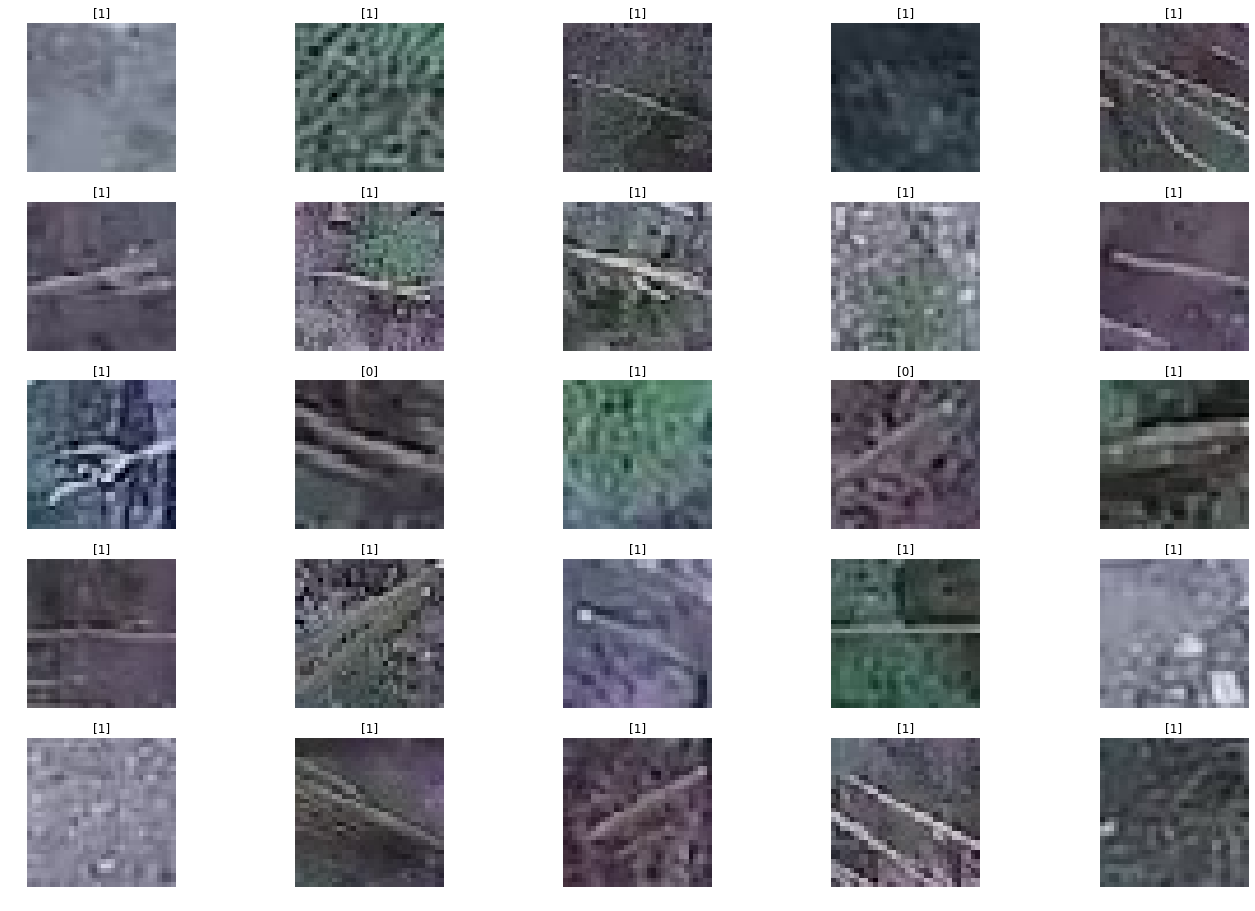

In [25]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = random.randint(0,len(test_images))
        ax[i,j].imshow(test_images[rnd_number])
        ax[i,j].set_title(pred[rnd_number])
        ax[i,j].axis('off')

'395228df50874f8cacbe18c681445acb.jpg'